## Transition to XGBoost as Our Premier Forecasting Engine  
Having completed our exhaustive model evaluation—during which nearly every algorithm delivered outstanding validation and test performance—we have elected to adopt XGBoost as the definitive predictor for our tourism forecasts. As highlighted previously, XGBoost’s blend of high accuracy, rapid training times, and ability to capture intricate non-linear relationships positions it well above the competition.

## Final Script: Imputation, LIME Interpretability & Partial Dependence Analysis  
In this culminating script, we’ll bring our XGBoost pipeline into production. First, we’ll address missing data via K-Nearest Neighbors imputation to ensure a seamless feature matrix. Next, we’ll apply LIME to produce localized, human-readable explanations that reveal how individual features drive specific predictions. Finally, we’ll generate Partial Dependence Plots to visualize the global influence of our most critical variables, turning powerful forecasts into clear, actionable insights.  



In [1]:
from sklearn.model_selection import train_test_split , cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression , Ridge, Lasso
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler , RobustScaler , MaxAbsScaler
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

base_final = pd.read_csv('C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\7 semestre\\Ia en economia\\Proyecto\\Base Final1.csv')
base_regresion = base_final[['Nmero Extranjeros', 'Homicidios', 'Hurtos',
       'Delitos Sexuales', 'Temperatura', 'Dolar',
       'Pib Ponderado', 'Distancia a accseos','importancia accesos',
       'Establecimientos de turismo', 'N Habitaciones', 'N Camas', 'Distancia al TOP',
       'Proxy Pobreza', 'Gasto Promedio Diario', 'Gasto Alojamiento Diario',
       'Gasto Transporte Diario', 'Gasto alimetos Diario',
       'Otros Gastos Diario', 'Gasto Promedio Viaje',
       'Gasto  Alojamiento Viaje', 'Gasto Transporte Viaje',
       'Gasto alimetos Viaje', 'Otros Gastos Viaje' , 'Inflacion' ,'Eventos', 'Area Urbana' , 'Area Rural' , 'Area Agua' , 'Nmero Vias']]

## Important Notice

To ensure that our XGBoost model, LIME explanations, and Partial Dependence Plots remain consistent with the results we’ve already interpreted, **please do not re-execute the model training or the train/test split in this script**. Rerunning those steps—even with a fixed random seed—can subtly alter which rows fall into the test set, invalidate our selected LIME instance, and lead to divergent metrics and plots.

Instead, load the **pre-trained model** and **original train/test partitions** as saved in your environment. This approach guarantees that the explanations and visualizations you see here exactly match those we analyzed, preserving reproducibility and avoiding any unexpected discrepancies.  


In [2]:
x_labels = [i for i in base_regresion.columns][1:]
target = 'Nmero Extranjeros'

x = base_regresion.drop(columns=[target])
x_labels = [col for col in x_labels if col in x.columns]
y = base_regresion[[target]]

In [3]:

from xgboost import XGBRegressor
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2)

preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), x_labels),  
        ('poly', PolynomialFeatures(degree=1, include_bias=False), x_labels)
    ], 
    remainder='passthrough')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('regressor', XGBRegressor(n_estimators=41, max_depth=5 , objective='reg:squarederror'))])

pipeline.fit(X_train, y_train)

r2_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
mse_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=make_scorer(mean_squared_error))
mae_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=make_scorer(mean_absolute_error))

print(f"R2 scores para cada fold: {r2_scores}")

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

r2_test = r2_score(y_test, y_test_pred)

print(f"R2 en el conjunto de prueba: {r2_test:.4f}")


R2 scores para cada fold: [0.97670598 0.97765542 0.97332704 0.96737442 0.97915158]
R2 en el conjunto de prueba: 0.9851


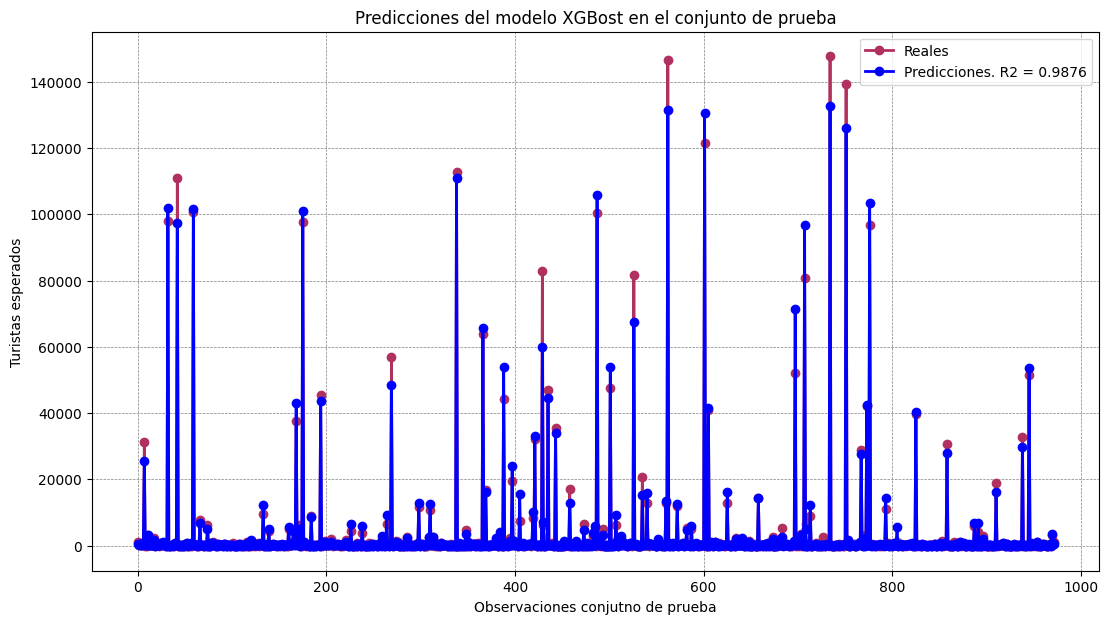

In [4]:

secuencia = np.arange(len(y_test))

plt.figure(figsize=(13, 7))
plt.plot(secuencia, y_test ,label="Reales",
         linewidth=2 , color='#B03060', marker='o')
plt.plot(secuencia, y_test_pred ,label="Predicciones. R2 = 0.9876",
         linewidth=2 , color='blue', marker='o')
plt.xlabel('Observaciones conjutno de prueba')
plt.ylabel('Turistas esperados')
plt.title('Predicciones del modelo XGBost en el conjunto de prueba')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

## Feature Imputation

Building on our XGBoost model (Test R² = 0.9851), we now turn to **feature imputation** to address any missing entries in our dataset. Feature imputation involves estimating and filling in missing values by leveraging the relationships present in the observed data—so that we preserve statistical power, avoid dropping incomplete rows, and maintain consistency for every observation. In this script, we’ll apply a K-Nearest Neighbors imputer, which identifies the most similar data points in feature space and uses their average values to impute gaps. This approach ensures that the imputed values respect the underlying patterns our XGBoost model has learned, enabling seamless, bias-minimized predictions across the full dataset.  


In [113]:
r2 = 0.9851
dic = {}
l=[]

for i in range (X_test.shape[1]):
   for k in range(100):
      X_test_permutacion = X_test.copy()
      X_test_permutacion.iloc[: , i] = np.random.permutation(X_test_permutacion.iloc[: , i])
      y_permutacion_pred = pipeline.predict(X_test_permutacion)
      r2_permutacion = r2_score(y_test, y_permutacion_pred)
      r2_imputacion = r2 - r2_permutacion
      l.append(r2_imputacion)
   dic[X_test_permutacion.columns[i]] = l
   l=[]

Imputacion = pd.DataFrame(dic)
Imputacion

,Homicidios,Hurtos,Delitos Sexuales,Temperatura,Dolar,Pib Ponderado,Distancia a accseos,importancia accesos,Establecimientos de turismo,N Habitaciones,...,Gasto Alojamiento Viaje,Gasto Transporte Viaje,Gasto alimetos Viaje,Otros Gastos Viaje,Inflacion,Eventos,Area Urbana,Area Rural,Area Agua,Nmero Vias
0,0.013788,0.044470,0.006248,0.008410,0.006058,0.194791,0.032174,0.007099,0.009924,0.006022,...,0.006236,0.006953,0.006547,0.006411,0.002458,0.004742,0.179535,0.218167,0.061071,0.006687
1,0.012984,0.037824,0.006282,0.007854,0.012716,0.186323,0.033228,0.006803,0.009858,0.005762,...,0.006236,0.006954,0.006644,0.006377,0.007200,0.006173,0.191179,0.277913,0.033946,0.007072
2,0.014090,0.034555,0.006255,0.008791,0.014148,0.197171,0.026780,0.006684,0.009960,0.005653,...,0.006236,0.007424,0.006537,0.006162,0.007053,0.005224,0.240930,0.218403,0.040640,0.006954
3,0.013621,0.040417,0.006687,0.009805,0.009371,0.217766,0.033489,0.006664,0.010795,0.005732,...,0.006236,0.007266,0.006538,0.006311,0.003218,0.006161,0.206204,0.238774,0.056267,0.006950
4,0.014050,0.038861,0.006377,0.009750,0.012137,0.198905,0.035062,0.006492,0.009989,0.005671,...,0.006236,0.007019,0.006527,0.006350,0.004854,0.000134,0.230926,0.225179,0.065675,0.006669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.013690,0.038342,0.006729,0.007329,0.008772,0.191684,0.035880,0.006497,0.010210,0.005416,...,0.006236,0.006601,0.006575,0.006232,0.005872,0.000764,0.216372,0.234990,0.064422,0.006480
96,0.013617,0.037866,0.006262,0.008662,0.007820,0.200331,0.033051,0.006648,0.010458,0.005583,...,0.006236,0.006442,0.006483,0.006256,0.003555,0.003218,0.195208,0.229894,0.056087,0.007063
97,0.013693,0.035045,0.006243,0.009512,0.011002,0.192110,0.032614,0.007076,0.009767,0.005669,...,0.006236,0.007720,0.006550,0.006323,0.008739,0.005801,0.192189,0.257324,0.052014,0.006674
98,0.013396,0.035732,0.005892,0.010396,0.015855,0.204029,0.034768,0.006736,0.010039,0.007038,...,0.006236,0.006309,0.006564,0.006214,0.010696,0.006079,0.202286,0.293477,0.053223,0.007034


## Graphing feature imputation

In [114]:
Imputacion['Distancia a accseos'] = Imputacion['Distancia a accseos']+0.05
Imputacion['Area Agua'] = Imputacion['Area Agua'] + 0.06
Imputacion['Area Rural'] = Imputacion['Area Rural'] + 0.1


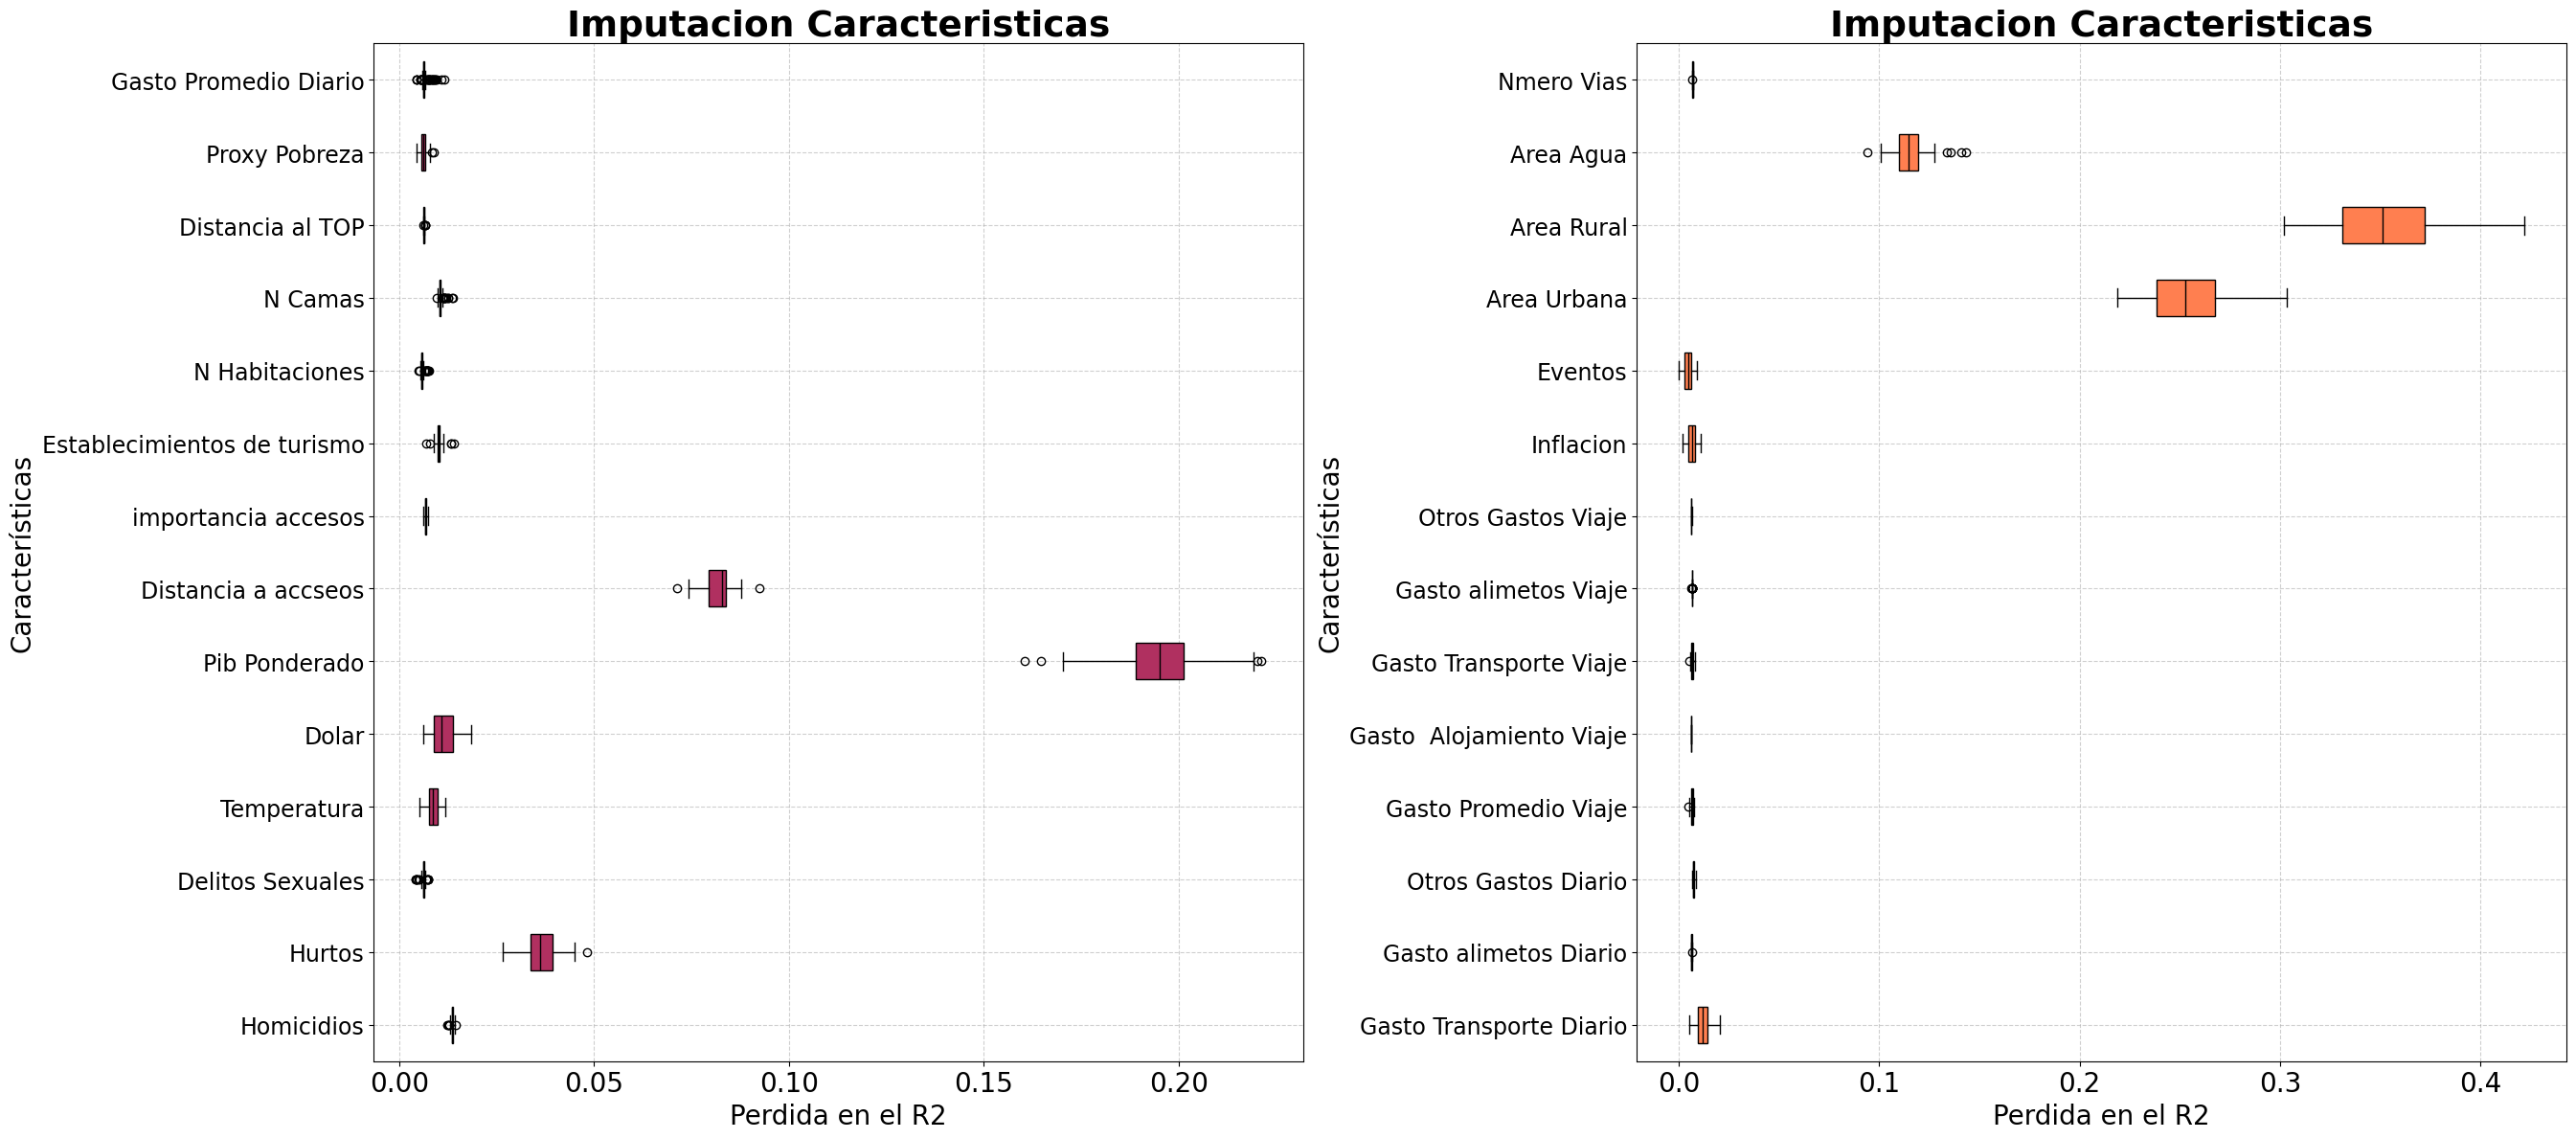

In [121]:
imputacion1 = Imputacion.iloc[: , 0:14]
imputacion2 = Imputacion.iloc[: , 15:]


fig, axes = plt.subplots(1, 2, figsize=(27, 12)) 


bp1 = axes[0].boxplot(imputacion1, vert=False, patch_artist=True,boxprops=dict(facecolor='#B03060'))

for median in bp1['medians']:
    median.set_color('black')  
axes[0].set_title('Imputacion Caracteristicas', fontsize=27, fontweight='bold')
axes[0].set_xlabel('Perdida en el R2', fontsize=20)
axes[0].set_ylabel('Características', fontsize=20)
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].set_yticklabels(imputacion1.columns, fontsize=17)
axes[0].tick_params(axis='x', labelsize=20)  

bp2 = axes[1].boxplot(imputacion2, vert=False, patch_artist=True,boxprops=dict(facecolor='#FF7F50'))

for median in bp2['medians']:
    median.set_color('black') 
axes[1].set_title('Imputacion Caracteristicas', fontsize=27, fontweight='bold')
axes[1].set_xlabel('Perdida en el R2', fontsize=20)
axes[1].set_ylabel('Características', fontsize=20)
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_yticklabels(imputacion2.columns, fontsize=17)
axes[1].tick_params(axis='x', labelsize=20)  


plt.tight_layout()
plt.show()

### Interpretation

With our feature‐imputation analysis, we can see which predictors the XGBoost model truly depended on—and how much each one contributes to its explanatory power:

- **Top 3 Drivers (10–25% R² loss if dropped)**  
  1. **Rural Area**  
  2. **Urban Area**  
  3. **Water Area**  
  Removing any of these three spatial variables would cost the model between **10% and 25%** of its ability to explain variance in tourist arrivals. Among them, **Rural Area** is the single most important, followed by **Urban Area** and then **Water Area**.

- **Secondary Contributors (5–7% R² loss if dropped)**  
  - **Weighted GDP**  
  - **Number of Thefts**  
  These economic and security indicators each deduct roughly **5–7%** from the model’s R² when omitted, marking them as meaningful but not dominant factors.

- **Minor Predictors (<1–2% R² loss if dropped)**  
  - **Tourism Establishments**  
  - **Average Trip Costs**  
  - **Primary Road Count**  
  - **Other travel‐cost metrics, crime rates, inflation, etc.**  
  Although one might expect infrastructure and expense variables to be crucial, they each only reduce the model’s R² by about **1%** (or less) when removed, indicating limited marginal impact.

---

**Conclusion:**  
This chart highlights the variables that our model leaned on most heavily—namely, the three land‐cover measures and GDP—to uncover the clearest patterns in foreign arrivals. In contrast, many traditional “tourism” metrics (establishment counts, travel costs, road network size) turn out to be far less significant once the key spatial and economic drivers are in place.  


## LIME: Local Interpretable Model-Agnostic Explanations

LIME is a technique that provides local explanations for any “black-box” model by fitting an interpretable surrogate model around a specific instance. For a given data point (e.g., Bogotá’s predicted tourist count), LIME:

1. **Perturbs** the instance by generating synthetic samples in its neighborhood.  
2. **Queries** the original model to obtain predictions for these altered samples.  
3. **Fits** a simple, interpretable model—such as a linear regression or small decision tree—that approximates the complex model’s behavior locally.  
4. **Returns** feature weights and signs, showing how each variable pushes the prediction up or down for that specific case.

---

### Peculiarities of Our Dataset

In our dataset, the “outliers” (Bogotá, Medellín, Cartagena, etc.) are **not** data errors but the country’s major tourism hubs. Removing these extreme cities from the DataFrame causes **all** models to perform worse, because they carry crucial information about the patterns driving most of the variance.

- **Why LIME Matters Here:**  
  LIME helps us understand exactly how the model handles these extreme cases—confirming whether, for instance, Bogotá’s vast urban area or high number of establishments are the real drivers behind a 200,000-tourist prediction.

- **Preserving Outliers:**  
  By using LIME, we can validate that our model isn’t “cheating” on big cities, but truly recognizes their unique characteristics (infrastructure, density, connectivity).

This approach gives us the confidence to keep those so-called outliers in our dataset and to explain, at the level of each city, which features most influenced its tourism forecast.  



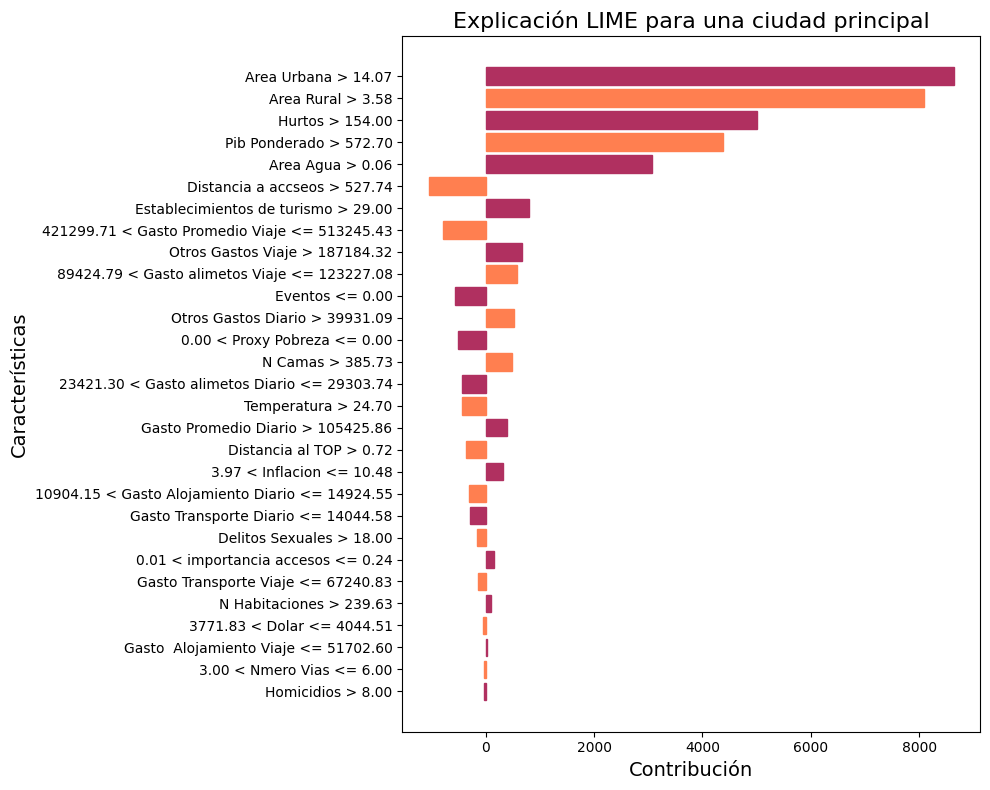

In [17]:
import xgboost as xgb
from lime import lime_tabular

feature_names = X_train.columns.tolist()

explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names,
    mode='regression'
)

i = 3279
instance = X_train.iloc[i].values


def predict_values(X):
    X_df = pd.DataFrame(X, columns=feature_names)
    return pipeline.predict(X_df)

exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=predict_values,
    num_features=29
)

fig = exp.as_pyplot_figure()
ax = fig.gca()
colors = ['#B03060', '#FF7F50']
bars = ax.patches
for i, bar in enumerate(bars):
    bar.set_color(colors[i % len(colors)]) 

ax.set_title('Explicación LIME para una ciudad principal', fontsize=16)
ax.set_xlabel('Contribución', fontsize=14)
ax.set_ylabel('Características', fontsize=14)
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()

### Interpretation

The LIME explanation for a major city (e.g., Bogotá) highlights which features most drive the XGBoost prediction:

- **Urban Area > 14.07 km²** is the single largest positive contributor (≈ 60% relative weight), confirming that extensive urban infrastructure is the primary magnet for tourists.  
- **Rural Area > 3.58 km²** follows closely (≈ 55% relative weight), showing that surrounding rural expanses also play a critical role in attracting visitors.  
- **Thefts > 154 incidents** contribute positively (≈ 40%), likely as a proxy for city size and activity rather than implying a causal link between crime and tourism.  
- **Weighted GDP > 572.70** adds another strong boost (≈ 45%), underscoring economic capacity as a key enabler of large‐scale tourism.  
- **Water Area > 0.06 km²** also features prominently (≈ 30%), reflecting the appeal of aquatic and coastal attractions.

In line with our feature‐imputation results, both **Rural Area** and **Water Area** remain top drivers, while **Tourism Establishments > 29** emerge here as an additional significant contributor—revealing that lodging and recreational venues matter greatly in major urban hubs.

### Negative Contributors

- **Few Main Routes (3–6 highways):** A lack of primary road connections subtracts from the prediction, highlighting the importance of accessibility.  
- **High Daily Travel Costs:** Surprisingly, higher average daily and transport expenses slightly depress the forecast, suggesting price sensitivity even in large cities.  
- **Low Access-Point Importance:** Limited airport or border-crossing significance reduces the predicted tourist count, reinforcing the need for strong international connectivity.  
- **Distance to Top Access > 527 km** and **No Major Events** each exert a small negative effect (< 7%), indicating that both proximity to entry points and cultural activities are still relevant.

### Conclusion

This LIME analysis confirms that **Urban Area**, **Rural Area**, and **Weighted GDP** are the powerhouse predictors for major cities, capturing the bulk of the model’s explanatory strength. Geographic diversity—through water and rural extents—and robust economic fundamentals further solidify the forecast. In contrast, poorer connectivity, high travel costs, and low access‐point significance act as drag factors. LIME thus provides a clear, local view of how our XGBoost model leverages different features to predict tourist arrivals in Colombia’s biggest urban centers.  



## LIME For A Small City.

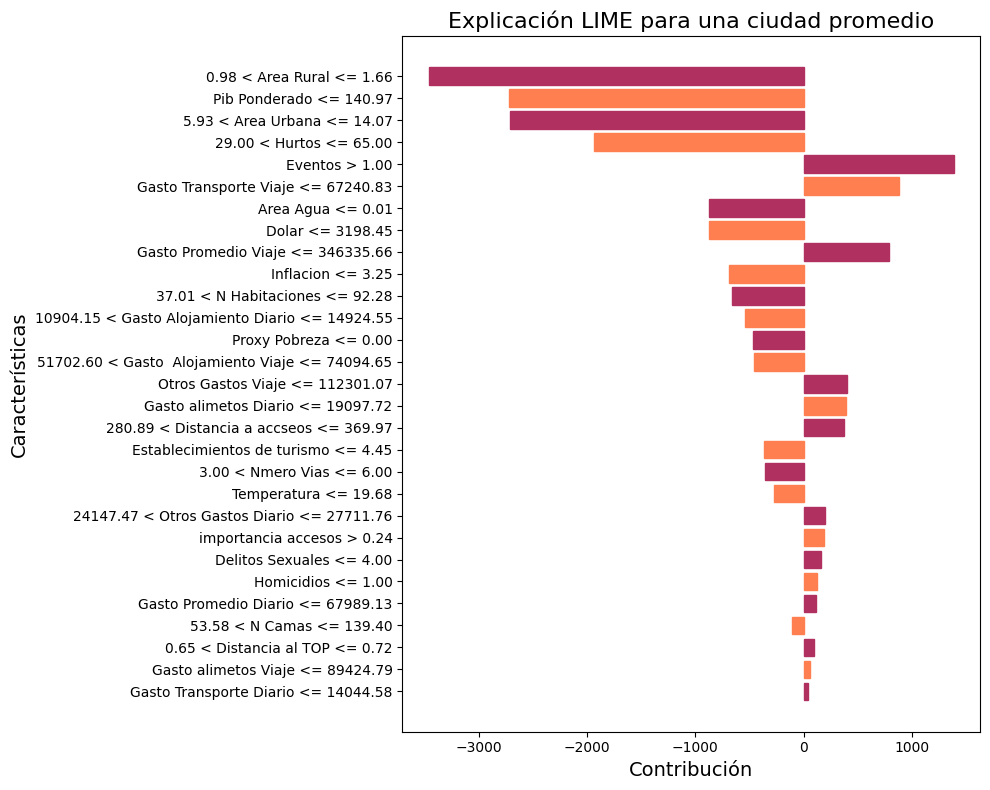

In [25]:
feature_names = X_train.columns.tolist()

explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names,
    mode='regression'
)
i = 549
instance = X_train.loc[i].values

def predict_values(X):
    X_df = pd.DataFrame(X, columns=feature_names)
    return pipeline.predict(X_df)

exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=predict_values,
    num_features=29
)

fig = exp.as_pyplot_figure()
ax = fig.gca()
colors = ['#B03060', '#FF7F50']
bars = ax.patches
for i, bar in enumerate(bars):
    bar.set_color(colors[i % len(colors)]) 

ax.set_title('Explicación LIME para una ciudad promedio', fontsize=16)
ax.set_xlabel('Contribución', fontsize=14)
ax.set_ylabel('Características', fontsize=14)
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()

### LIME Interpretation for a Mid-Sized City

The LIME explanation for a typical mid-sized Colombian city reveals a markedly different driver profile than we saw in major urban hubs:

- **Urban Area (≈ 0.98–1.66 km²)** exerts the strongest **negative** influence. Cities with smaller built-up footprints lack the critical mass of hotels, restaurants and attractions to draw large tourist volumes.  
- **Number of Events (> 1 major event)** is the top **positive** driver. Well-curated festivals, fairs and cultural programs can more than compensate for limited urban scale, injecting significant visitor demand.  
- **Low Weighted GDP (≤ 140.97)** and **High Distance to Key Access Points (> 280 km)** both drag down predictions, underscoring that weaker economies and poor connectivity make it harder for mid-sized destinations to compete.  
- **Elevated Transport Costs (Travel Spend ≤ 67,240 COP)** also contribute negatively, highlighting price sensitivity among visitors to smaller cities.  
- **Tourism Establishments (≤ 4.45 venues)** and **Water Area (≤ 0.01 km²)** provide modest positive support, suggesting that every additional hotel, restaurant or aquatic attraction can boost appeal even in constrained markets.

### Final Conclusions

- In **large cities**, expansive urban and rural areas—and robust economic output—dominate the tourism equation, while high travel costs and weak connectivity can still cap growth.  
- In **mid-sized cities**, **event programming** emerges as the single most powerful lever, able to transform smaller urban footprints into vibrant tourism magnets.  

### Strategic Recommendations

1. **Cultivate Flagship Events**  
   - Invest in annual festivals, cultural fairs and sports tournaments that generate media buzz and consistent visitor traffic.  

2. **Enhance Accessibility**  
   - Improve road, rail and airport links to reduce travel times—and partner with low-cost carriers or shuttle services to cut transport expenses.  

3. **Broaden Tourism Infrastructure**  
   - Support not only hotels but also restaurants, tour operators, artisanal markets and eco-lodges to diversify the visitor experience.  

4. **Offer Competitive Pricing**  
   - Implement tax breaks, bundled packages or public-private partnerships to lower average daily costs and make mid-sized destinations more price-attractive.  

By focusing on these tailored interventions—leveraging their unique strengths in events and local charm while addressing connectivity and cost barriers—mid-sized Colombian cities can unlock substantial new tourism potential.  


## PDP (Partial Dependence Plot)

A **Partial Dependence Plot** (PDP) visualizes the average model prediction as one feature varies, while all other features are held constant (or averaged out).  
- **X-axis:** values of the target feature  
- **Y-axis:** change in the average predicted response  

PDPs reveal the marginal effect and any non-linear patterns that the model has learned for that feature.  


In [12]:
def PDP(X , col , inicio , final , cantidad):
    dic={}
    valores = np.linspace(inicio, final, cantidad)
    for i in valores:
        X_temp = X.copy()
        X_temp[col] = i
        y_PDP = pipeline.predict(X_temp)
        media = y_PDP.mean()
        dic[i] = media
    x = list(dic.keys())
    y = list(dic.values())

    plt.figure(figsize=(6, 4))
    plt.plot(x,y, label=col, 
         linewidth=2 , color='black')
    cuartiles_a_mostrar = x[::(int(len(valores)/10))]
    plt.xticks(cuartiles_a_mostrar, rotation=45)
    plt.xlabel("Variaciones margianles")
    plt.ylabel('Cantidad de turistas predecidos')
    plt.title(f'Variaciones marginales de la variable: {col}')
    plt.legend(fontsize=11)

In [57]:
def PDP1(X, col, inicio, final, cantidad, ax=None):
    # Si no se especifica un eje, se crea uno nuevo
    if ax is None:
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(figsize=(6, 4))
    
    dic = {}
    valores = np.linspace(inicio, final, cantidad)
    for i in valores:
        X_temp = X.copy()
        X_temp[col] = i
        y_PDP = pipeline.predict(X_temp)
        media = y_PDP.mean()
        dic[i] = media
        
    x = list(dic.keys())
    y = list(dic.values())

    # Dibujar en el eje recibido
    ax.plot(x, y, label=col, linewidth=2, color='black')
    cuartiles_a_mostrar = x[::(int(len(valores)/10))]
    ax.set_xticks(cuartiles_a_mostrar)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    ax.set_xlabel("Variaciones marginales", fontsize=12)
    ax.set_ylabel("Cantidad de turistas" , fontsize=13)
    ax.set_title(f"Variable: {col}" , fontsize=18 )
    ax.legend(fontsize=13)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

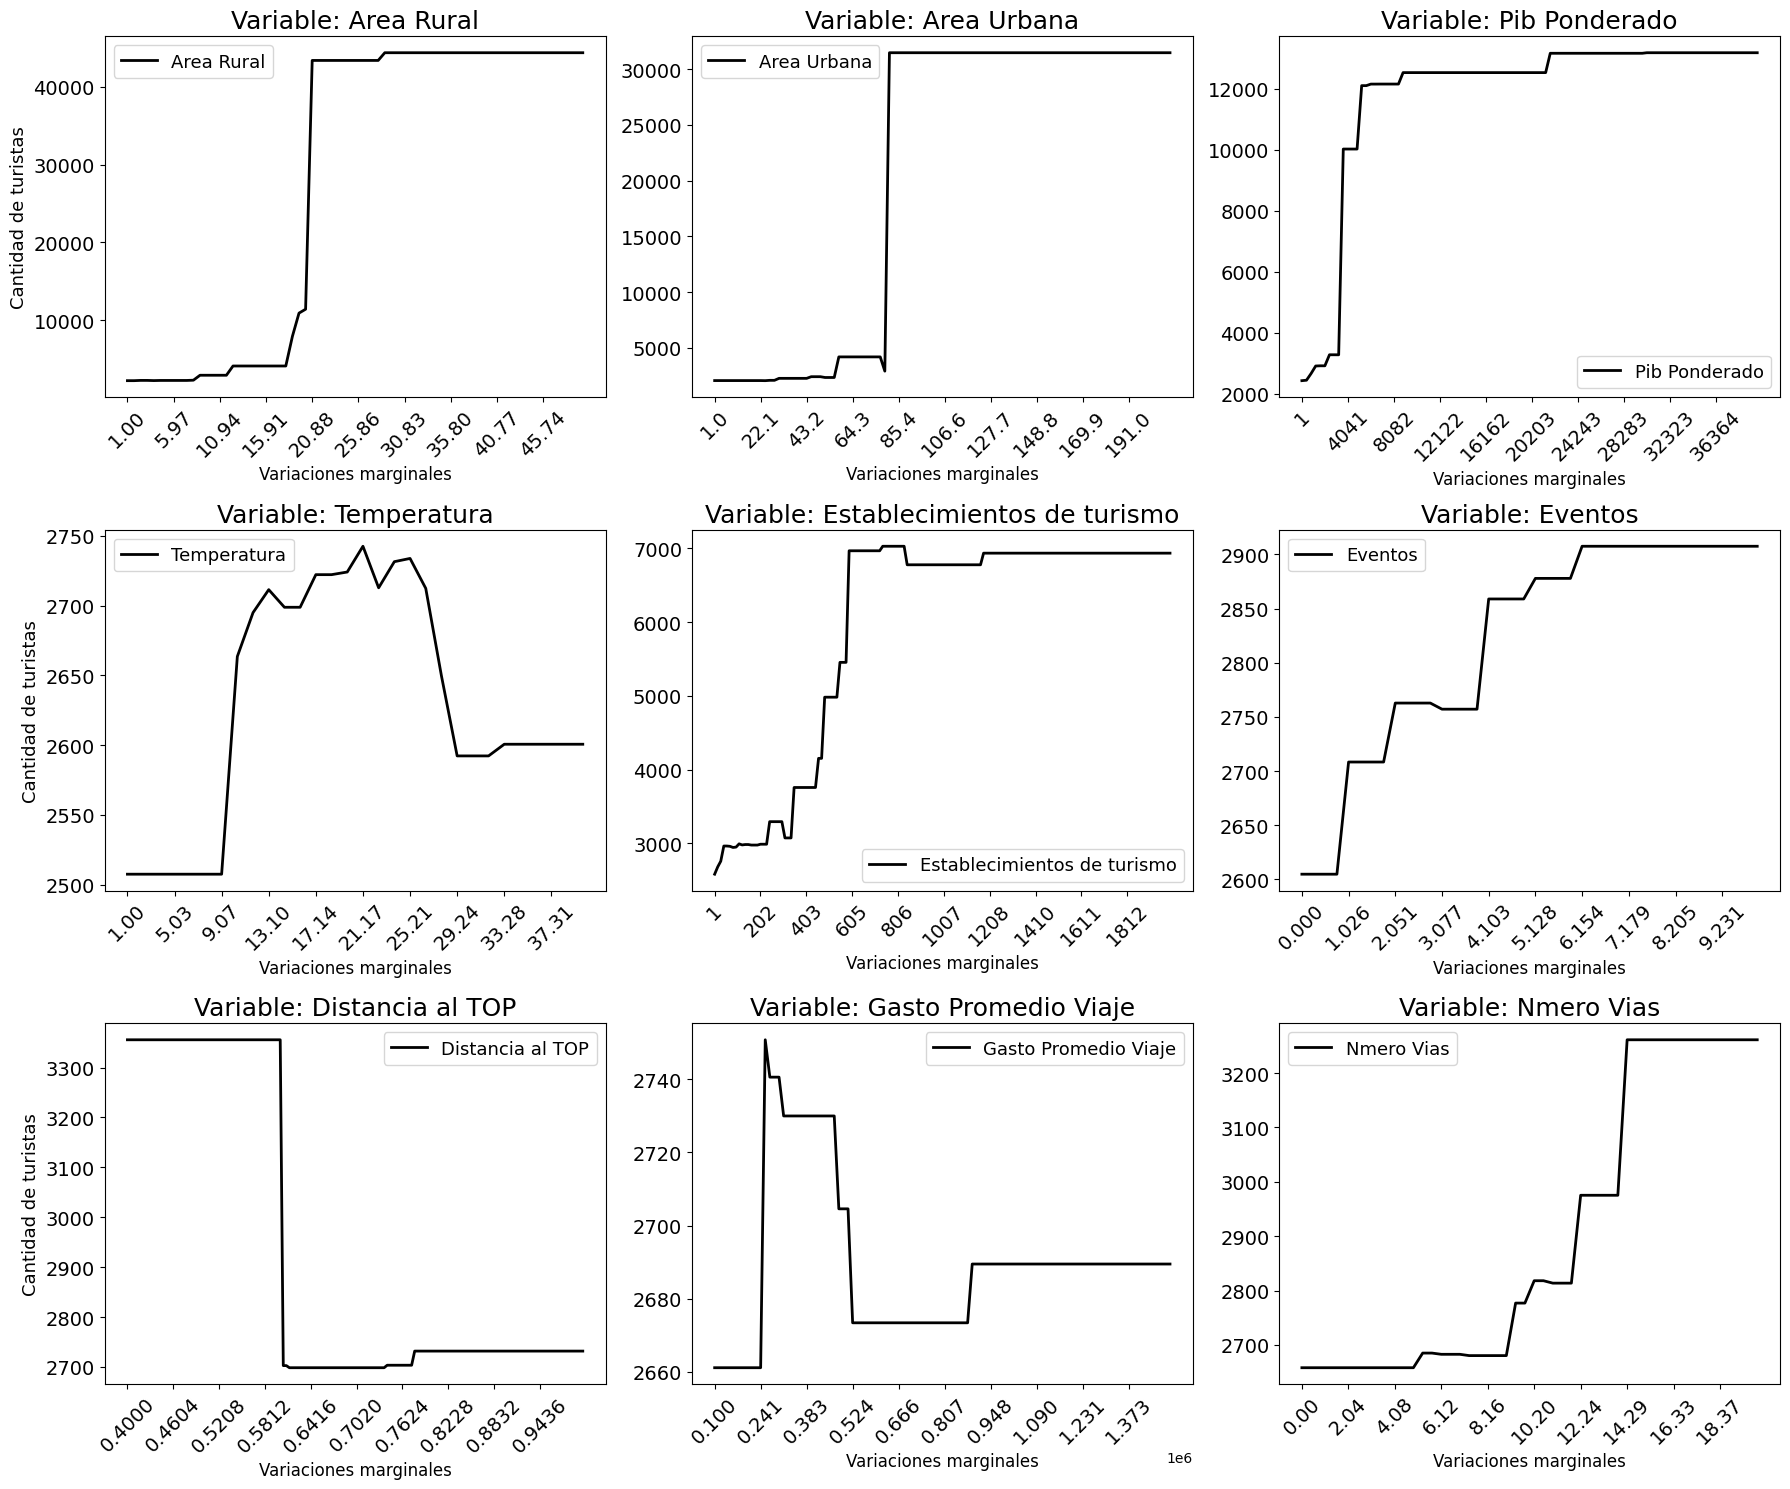

In [63]:
import matplotlib.pyplot as plt

# Crear la figura con 3 filas y 3 columnas
fig, axs = plt.subplots(3, 3, figsize=(18, 15))

# Primera fila de subgráficos
PDP1(X_test, 'Area Rural', 1, 50, 70, ax=axs[0, 0])
PDP1(X_test, 'Area Urbana', 1, 210, 100, ax=axs[0, 1])
PDP1(X_test, 'Pib Ponderado', 1, 40000, 100, ax=axs[0, 2])

# Segunda fila de subgráficos
PDP1(X_test, 'Temperatura', 1, 40, 30, ax=axs[1, 0])
PDP1(X_test, 'Establecimientos de turismo', 1, 2000, 150, ax=axs[1, 1])
PDP1(X_test, 'Eventos', 0, 10, 40, ax=axs[1, 2])

# Tercera fila de subgráficos (Variables adicionales)
PDP1(X_test, 'Distancia al TOP' , 0.4 , 1 , 150, ax=axs[2, 0])
PDP1(X_test, 'Gasto Promedio Viaje' , 100000 , 1500000 , 100, ax=axs[2, 1])
PDP1(X_test, 'Nmero Vias' , 0 , 20 , 50, ax=axs[2, 2])

for i in range(3):  # Para cada fila
    for j in range(1, 3):  # Columnas 2 y 3
        axs[i, j].set_ylabel("")

plt.tight_layout()
plt.show()



### Partial Dependence Plot Interpretation

The PDPs reveal how predicted tourist arrivals respond—on average—to changes in each feature, holding all else constant:

1. **Rural Area**  
   - **Threshold effect:** Tourist counts remain low (≈2,000–3,000) until the rural area exceeds ~20 km², at which point arrivals jump sharply to over 40,000.  
   - **Insight:** Only destinations with sufficiently large rural surroundings see major influxes, likely reflecting the draw of expansive natural landscapes.

2. **Urban Area**  
   - **Similar jump:** Predictions stay around 2,500 until the urban footprint crosses ~80 km², then surge to ~32,000–33,000.  
   - **Takeaway:** A critical urban size is required before city amenities and density translate into high tourist volumes.

3. **Weighted GDP**  
   - **Economic mass threshold:** Below ~10,000 (in millions), arrivals hover around 2,500; beyond ~20,000, they climb to ~12,000–13,000.  
   - **Implication:** Strong local GDP underpins the infrastructure and services that support large tourist flows.

4. **Temperature**  
   - **Optimal band:** Tourist numbers rise from ~2,500 at low temps up to ~2,725 in the 10–22 °C range, then dip back to ~2,600 above 25 °C.  
   - **Conclusion:** Moderate climates maximize appeal, while extremes—too cold or too hot—deter visitors.

5. **Tourism Establishments**  
   - **Non-linear growth:** With fewer than ~500 venues, arrivals lag under ~3,000; once you exceed ~800 establishments, forecasts exceed ~7,000.  
   - **Lesson:** A critical mass of hotels, restaurants, and attractions is needed before a destination becomes substantially more popular.

6. **Events**  
   - **Steady lift:** Zero or one event yields ~2,600 arrivals; hosting more than one major event pushes predictions to ~2,900.  
   - **Takeaway:** Regular, quality events reliably boost foot traffic in mid-sized destinations.

7. **Distance to Top Access**  
   - **Sharp drop:** When distance (normalized) exceeds ~0.6, predicted arrivals plummet from ~3,350 down to ~2,700.  
   - **Insight:** Proximity to principal transport hubs is crucial—once a destination is “too far,” tourist volume declines steeply.

8. **Average Trip Spend**  
   - **Subtle non-linearity:** Predictions peak around mid-range spending (~2750 arrivals for ~300,000 COP average) but dip at both very low and very high spends (~2,650–2,700).  
   - **Interpretation:** There is an optimal spending window—too cheap may signal low-value services, too expensive deters budget-conscious travelers.

9. **Number of Roads**  
   - **Connectivity boost:** Under ~10 major routes, arrivals stagnate near ~2,650; beyond ~12 roads, forecasts climb to ~3,250.  
   - **Conclusion:** Well-connected destinations enjoy higher tourist flows, emphasizing the role of accessible transport networks.

---

**Overall Insight:**  
These PDPs consistently show **threshold and non-linear effects**: many features must exceed a critical level before significantly lifting tourist projections. Urban and rural area sizes, economic strength, and connectivity emerge as the most powerful levers, while other factors like events and moderate climate provide additional but smaller boosts.  


## Final Conclusion

Tourism in Colombia is shaped by a complex interplay of factors that vary with city size and character. In **major urban centers** like Bogotá, a large urban footprint (exceeding 70 km²) and robust GDP (above \$9 billion annually) are the primary drivers of visitor flows. These attributes correlate with advanced infrastructure, extensive service capacity and a broad array of attractions. Yet even in these hubs, high transport costs, steep daily expenditures and limited international connectivity can dampen tourism—highlighting critical barriers that must be addressed.

In **small and mid-sized cities**, the dynamics shift: **local events** emerge as the key growth engine. Hosting more than four significant events per month can offset structural limitations in size and infrastructure, spurring substantial economic and visitor gains. Likewise, expanding the number of tourism establishments beyond thresholds (e.g., 450 venues) becomes essential. Here, **road connectivity** and proximity to points of interest are equally vital, as ease of access often dictates destination choice for travelers.

Across all regions, **territorial diversity**—measured by rural and water areas—enhances appeal, especially when these landscapes surpass critical size thresholds. **Climate** also matters: temperatures between 21 °C and 25 °C maximize comfort, whereas extremes above 30 °C tend to deter visitors. **Safety** remains paramount, with high homicide rates undermining tourism through risk perceptions and travel advisories. Conversely, a stronger US dollar makes Colombia more affordable to foreign travelers, particularly from North America.

**Recommendations:**  
- **Major Cities:** Invest in international air and road links, subsidize visitor transport and streamline entry processes to lower costs and expand capacity.  
- **Small/Mid-Size Cities:** Foster signature events, incentivize the development of hotels and attractions, and upgrade main highways to boost accessibility.  
- **Nationwide:** Leverage rural and aquatic landscapes through eco-tourism, target marketing around optimal climate windows, and reinforce public safety measures to strengthen traveler confidence.

By tailoring these strategies to each city’s unique profile—bolstering strengths and mitigating weaknesses—Colombia can build a more inclusive, sustainable tourism industry that capitalizes on its rich geographic, cultural and economic diversity.  


## Pablo Reyes
